# Homework 11 Data Competition

## Import data

In [53]:
#include libraries
import numpy as np
import pandas as pd

In [54]:
#import modules
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

#show data
train_data.iloc[:,:50].columns

Index(['destination_Home', 'destination_No Urgent Place', 'destination_Work',
       'passenger_Alone', 'passenger_Friend(s)', 'passenger_Kid(s)',
       'passenger_Partner', 'weather_Rainy', 'weather_Snowy', 'weather_Sunny',
       'temperature', 'time_10AM', 'time_10PM', 'time_2PM', 'time_6PM',
       'time_7AM', 'coupon_Bar', 'coupon_Carry out & Take away',
       'coupon_Coffee House', 'coupon_Restaurant(20-50)',
       'coupon_Restaurant(<20)', 'expiration_1d', 'expiration_2h',
       'gender_Female', 'gender_Male', 'age_21', 'age_26', 'age_31', 'age_36',
       'age_41', 'age_46', 'age_50plus', 'age_below21',
       'maritalStatus_Divorced', 'maritalStatus_Married partner',
       'maritalStatus_Single', 'maritalStatus_Unmarried partner',
       'maritalStatus_Widowed', 'has_children', 'education_Associates degree',
       'education_Bachelors degree',
       'education_Graduate degree (Masters or Doctorate)',
       'education_High School Graduate', 'education_Some High School',

In [55]:
train_data.iloc[:,50:].columns

Index(['occupation_Computer & Mathematical',
       'occupation_Construction & Extraction',
       'occupation_Education&Training&Library',
       'occupation_Farming Fishing & Forestry',
       'occupation_Food Preparation & Serving Related',
       'occupation_Healthcare Practitioners & Technical',
       'occupation_Healthcare Support',
       'occupation_Installation Maintenance & Repair', 'occupation_Legal',
       'occupation_Life Physical Social Science', 'occupation_Management',
       'occupation_Office & Administrative Support',
       'occupation_Personal Care & Service',
       'occupation_Production Occupations', 'occupation_Protective Service',
       'occupation_Retired', 'occupation_Sales & Related',
       'occupation_Student', 'occupation_Transportation & Material Moving',
       'occupation_Unemployed', 'income_$100000 or More',
       'income_$12500 - $24999', 'income_$25000 - $37499',
       'income_$37500 - $49999', 'income_$50000 - $62499',
       'income_$62500 

In [56]:
train_data.shape

(3623, 110)

## Check for missing values

In [57]:
train_data.isnull().sum().any()

False

In [58]:
test_data.isnull().sum().any()

False

## Data Manipulation

#### Test Train Split

In [59]:
y_train = train_data['accept']
X_train = train_data.loc[:, train_data.columns != 'accept']

y_test = test_data['accept']
X_test = test_data.loc[:, train_data.columns != 'accept']

X_train.columns

Index(['destination_Home', 'destination_No Urgent Place', 'destination_Work',
       'passenger_Alone', 'passenger_Friend(s)', 'passenger_Kid(s)',
       'passenger_Partner', 'weather_Rainy', 'weather_Snowy', 'weather_Sunny',
       ...
       'Restaurant20To50_1~3', 'Restaurant20To50_4~8', 'Restaurant20To50_gt8',
       'Restaurant20To50_less1', 'Restaurant20To50_never', 'toCoupon_GEQ5min',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp'],
      dtype='object', length=109)

## Feature Selection

To make sure the best features are selected, cross validation is being done to optimize the results

In [60]:
#import modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#create basic classifier
rf = RandomForestClassifier(random_state=100)

#grid search parameters
params = {
    'n_estimators': [50, 100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2']
}

#create and fit
#CV_rf = GridSearchCV(estimator=rf, param_grid=params, cv=5)
#CV_rf.fit(X_train, y_train)

#show best params
#CV_rf.best_params_

{'max_features': 'auto', 'n_estimators': 500}

Now that the best hyper-parameters are found, they can be fit onto a new random forest

In [61]:
#create optimized random forest
rf_optimized = RandomForestClassifier(random_state=100, n_estimators=500, max_features='auto')

#fit
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(max_features='auto', n_estimators=500, random_state=100)

In [62]:
#import module
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf_optimized.predict(X_test))

0.7213103393520682

In [63]:
roc_auc_score(y_train, rf_optimized.predict(X_train))

0.9996794871794872

Now, the feature importances can be found and sorted out

In [64]:
# get features importances
feature_importances = pd.DataFrame(rf_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance'])
feature_importances = feature_importances.sort_values('importance',ascending=False)

The features can then be plotted out

<AxesSubplot:title={'center':'Feature Importance'}>

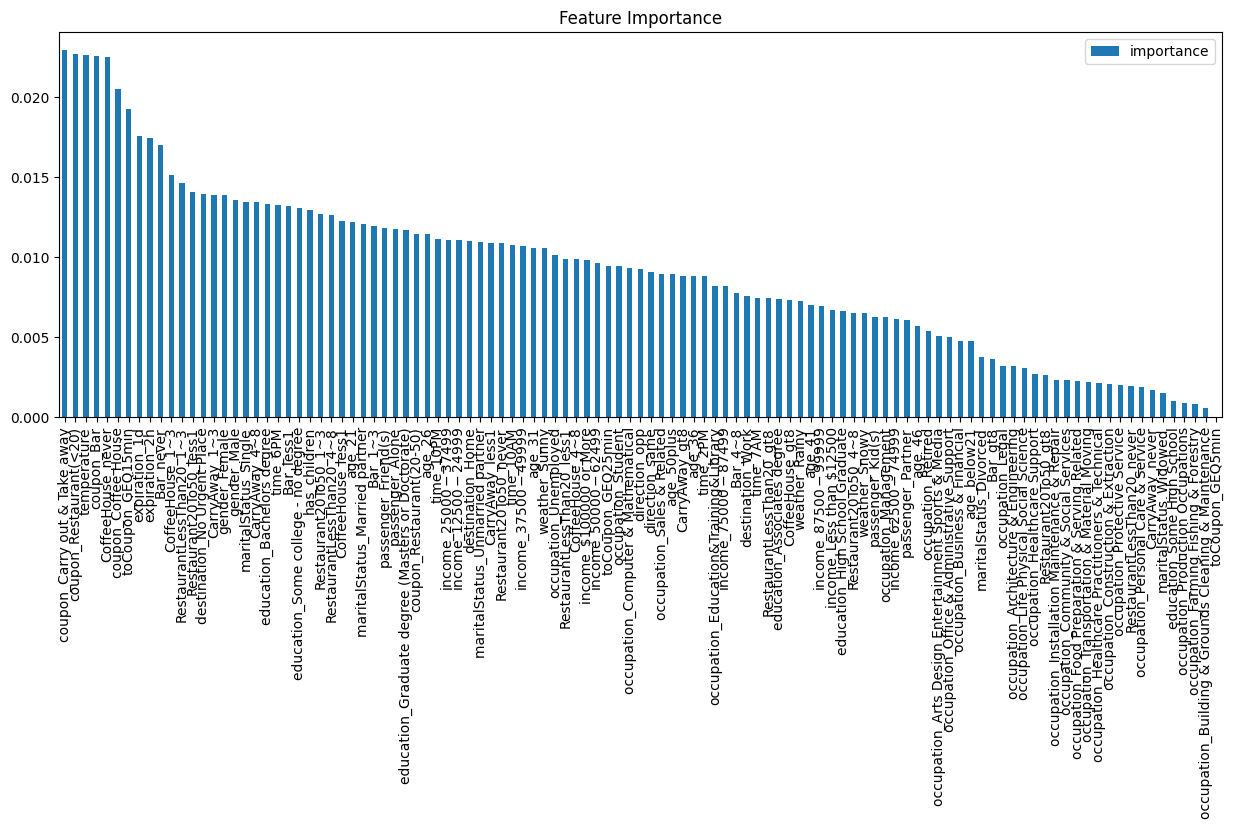

In [65]:
#import module
import matplotlib.pyplot as plt

#plot feature importances
feature_importances.plot(kind = 'bar',figsize=(15,5),
                         title='Feature Importance')

In [95]:
#get all features with importance of >=.0045
important_features = feature_importances.loc[feature_importances['importance'] >= .010]

#select most important features
X_train_imp = X_train[important_features.index]
X_test_imp = X_test[important_features.index]

#show results
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3623 entries, 0 to 3622
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype
---  ------                                            --------------  -----
 0   coupon_Carry out & Take away                      3623 non-null   int64
 1   coupon_Restaurant(<20)                            3623 non-null   int64
 2   temperature                                       3623 non-null   int64
 3   coupon_Bar                                        3623 non-null   int64
 4   CoffeeHouse_never                                 3623 non-null   int64
 5   coupon_Coffee House                               3623 non-null   int64
 6   toCoupon_GEQ15min                                 3623 non-null   int64
 7   expiration_1d                                     3623 non-null   int64
 8   expiration_2h                                     3623 non-null   int64
 9   Bar_never                                

## Hyperparameter tuning

In [99]:
#create basic classifier
rf = RandomForestClassifier(random_state=100)

#grid search parameters
params = {
    'n_estimators': [50, 100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 10]
}

#create and fit
CV_rf = GridSearchCV(estimator=rf, param_grid=params, cv=5)
CV_rf.fit(X_train_imp, y_train)

#show best params
CV_rf.best_params_

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}

In [104]:
#create optimized random forest
rf_optimized = RandomForestClassifier(random_state=100, n_estimators=100, max_features='log2', max_depth=25)

#fit
rf_optimized.fit(X_train_imp, y_train)

RandomForestClassifier(max_depth=25, max_features='log2', random_state=100)

In [105]:
#import module
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf_optimized.predict(X_test_imp))

0.7079837842536425

In [98]:
roc_auc_score(y_train, rf_optimized.predict(X_train_imp))

0.9975061212821756